### Import

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import random
import glob
import scipy.stats as stats

# Configurando o pandas para mostrar todas as colunas
pd.set_option('display.max_columns', 500)

# Dataprep

## convert csv in .db 

In [3]:
def convert_csv_to_sql(path_to_data, db_name, chunksize):
    '''
    Função para conversão de arquivos csv em banco de dados sqlite3.
    
    INPUTS:
        path_name : str
            Caminho para os dados em formato csv a serem convertidos.
            
        db_name: str
            Nome do banco de dados a receber os dados
            
        chunksize : int
            Tamanho do lote de carregamento do arquivo csv.
    '''
    # Cria conexao/banco de dados
    db = sqlite3.connect(db_name)

    # Lê todos os arquivos do caminho especificado em formato csv 
    files = glob.glob(f'{path_to_data}/*.CSV')
    # Para cada um dos arquivos
    for file in files:

        # Define o nome da tabela como sendo o nome do arquivo sem o .csv
        table_name = file.split('/')[-1].split('.CSV')[0]

        # Carrega o arquivo indicado em chunks (lotes) de forma
        # a permitir operação com dataframes grandes demais
        df_chunks = pd.read_csv(file, sep='|', encoding='latin1', chunksize=chunksize)

        # Para cada lote ("pedaço") do dataframe
        for df in df_chunks:

            # Escreve o pedaço no banco
            df.to_sql(
                name=table_name, # Define o nome da tabela a receber as informações (ou ser criada)
                index=False, # Não escreve o índice do dataframe na tabela
                if_exists='append', # Se a tabela já existir, adiciona as informações abaixo das existentes
                con=db # Define em qual banco os dados serão inseridos
            )

In [4]:
# Utilizando função para conversão dos csvs em banco de dados sqlite
# Descomentar a linha abaixo e ajustar o path para o seu projeto

convert_csv_to_sql(r'./dados', 'desafio_1.db', chunksize=100000)

/var/folders/33/lx7s1lc53td6kjf6fs9ybgh00000gn/T/ipykernel_756/357598669.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for df in df_chunks:
/var/folders/33/lx7s1lc53td6kjf6fs9ybgh00000gn/T/ipykernel_756/357598669.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for df in df_chunks:
/var/folders/33/lx7s1lc53td6kjf6fs9ybgh00000gn/T/ipykernel_756/357598669.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for df in df_chunks:
/var/folders/33/lx7s1lc53td6kjf6fs9ybgh00000gn/T/ipykernel_756/357598669.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for df in df_chunks:
/var/folders/33/lx7s1lc53td6kjf6fs9ybgh00000gn/T/ipykernel_756/357598669.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  f

### SQL Read

In [3]:
# Conecta ao banco
db = sqlite3.connect('desafio_1.db')

# Inspeciona tabelas no db
pd.read_sql_query('SELECT tbl_name FROM sqlite_master', db)

,tbl_name
0,DM_CURSO
1,DM_ALUNO
2,DM_LOCAL_OFERTA
3,TB_AUX_CINE_BRASIL
4,DM_IES
5,DM_DOCENTE


In [4]:
# Conta número de linhas na tabela DM_CURSO
pd.read_sql_query(r'SELECT COUNT(NU_ANO_CENSO) from DM_CURSO', db)

,COUNT(NU_ANO_CENSO)
0,38256


In [5]:
query = '''
SELECT COUNT(ID_ALUNO) as ALUNOS
FROM DM_ALUNO
WHERE TP_SITUACAO = 2
'''

pd.read_sql_query(query, db)

,ALUNOS
0,7186970


# EDA

### Número de universidades públicas e privadas por estado e outra com número de alunos por universidade

In [6]:
query = '''
SELECT SG_IES as SIGLA_UNIVERSIDADE, CO_IES as CODIGO_UNIVERSIDADE, TP_CATEGORIA_ADMINISTRATIVA as CATEGORIA, CO_UF as CODIGO_ESTADO
FROM DM_IES
WHERE TP_ORGANIZACAO_ACADEMICA = 1
'''

df_ies = pd.read_sql_query(query, db)
df_ies

,SIGLA_UNIVERSIDADE,CODIGO_UNIVERSIDADE,CATEGORIA,CODIGO_ESTADO
0,UFMT,1,1,51
1,UNB,2,1,53
2,UFS,3,1,28
3,UFAM,4,1,13
4,UFOP,6,1,31
...,...,...,...,...
194,UNIDERP,671,4,50
195,UNILAB,15497,1,23
196,None,319,5,35
197,UNESP,56,2,35


In [7]:
df_estados = pd.read_excel(r'./anexos/ANEXO I - Dicionario de Variaveis e Tabelas Auxiliares/Tabela Estados IBGE.xlsx')
df_estados

,Código da UF,UF,Estado
0,12,AC,Acre
1,27,AL,Alagoas
2,13,AM,Amazonas
3,16,AP,Amapá
4,29,BA,Bahia
5,23,CE,Ceará
6,53,DF,Distrito Federal
7,32,ES,Espírito Santo
8,52,GO,Goiás
9,21,MA,Maranhão


In [10]:
df_ies = df_ies.merge(df_estados, how = 'left', left_on='CODIGO_ESTADO', right_on='Código da UF')
df_ies.drop(['CODIGO_ESTADO', 'Estado', 'Código da UF'], inplace=True, axis=1)
df_ies

,SIGLA_UNIVERSIDADE,CODIGO_UNIVERSIDADE,CATEGORIA,UF
0,UFMT,1,1,MT
1,UNB,2,1,DF
2,UFS,3,1,SE
3,UFAM,4,1,AM
4,UFOP,6,1,MG
...,...,...,...,...
194,UNIDERP,671,4,MS
195,UNILAB,15497,1,CE
196,None,319,5,SP
197,UNESP,56,2,SP


In [8]:
def get_tipo(categoria):
    if categoria <= 3:
        return 'PUBLICA'
    else:
        return 'PRIVADA'

In [12]:
df_ies['TIPO'] = df_ies['CATEGORIA'].map(lambda x: get_tipo(x))
df_ies

,SIGLA_UNIVERSIDADE,CODIGO_UNIVERSIDADE,CATEGORIA,UF,TIPO
0,UFMT,1,1,MT,PUBLICA
1,UNB,2,1,DF,PUBLICA
2,UFS,3,1,SE,PUBLICA
3,UFAM,4,1,AM,PUBLICA
4,UFOP,6,1,MG,PUBLICA
...,...,...,...,...,...
194,UNIDERP,671,4,MS,PRIVADA
195,UNILAB,15497,1,CE,PUBLICA
196,None,319,5,SP,PRIVADA
197,UNESP,56,2,SP,PUBLICA


In [9]:
pd.pivot_table(df_ies, values='SIGLA_UNIVERSIDADE', columns=['UF','TIPO'], aggfunc='count').transpose()

KeyError: 'UF'

<AxesSubplot:title={'center':'Contagem de Tipo de Universidade por UF'}, xlabel='UF', ylabel='Count'>

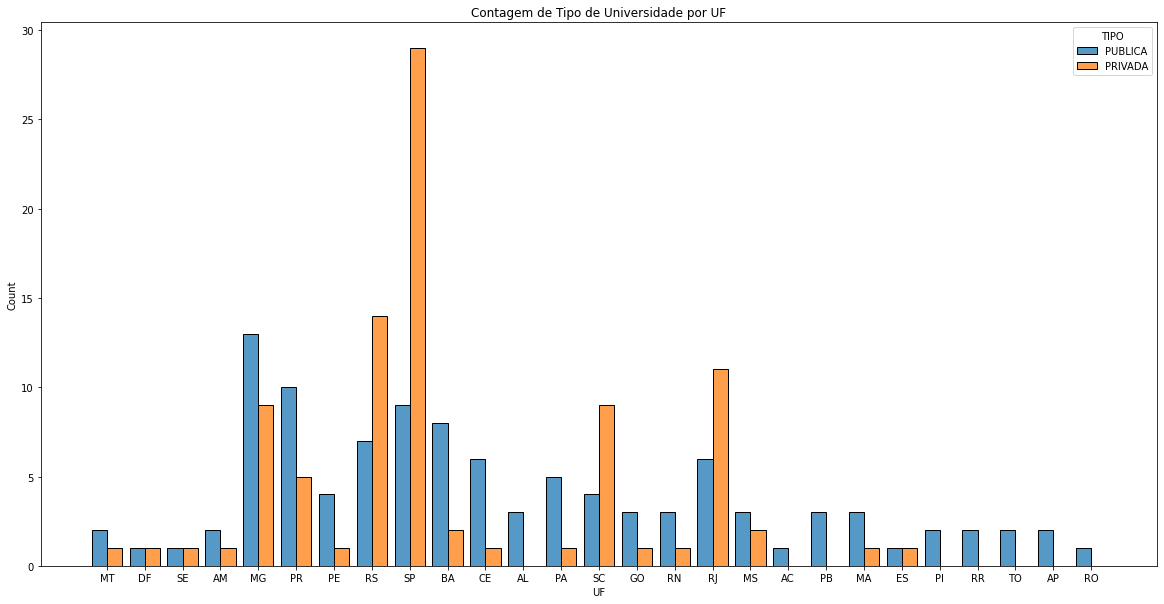

In [14]:
plt.figure(figsize=(20,10))
plt.title('Contagem de Tipo de Universidade por UF')
sns.histplot(data=df_ies, x='UF',hue='TIPO', multiple='dodge', shrink=.8)

Repare na concentração de universidades nas Regiões Sul e Sudeste.

In [11]:
query_join = '''
            SELECT ALUNOS.ID_ALUNO as ID,
            IES.SG_IES as SIGLA_UNIVERSIDADE
            FROM DM_ALUNO as ALUNOS
            LEFT JOIN
                DM_IES as IES
                ON ALUNOS.CO_IES = IES.CO_IES
            WHERE ALUNOS.TP_SITUACAO = 2
'''

df_alunos = pd.read_sql_query(query_join,db)
df_alunos

,ID,SIGLA_UNIVERSIDADE
0,2ECD7C9BEA7DCEBC31B9F2874D454F71,UFMT
1,3EA3DF175677D93C4FDD47865E89B92A,UFMT
2,EF1C01E9B84BEB8D6AA9702F59A90410,UFMT
3,E92DBC6D54AD8AC7419AC6818C9D4C3B,UFMT
4,442253EDCC14C59DA844B46DE6BFC49C,UFMT
...,...,...
7186965,AFB1C88C61C115085A2A1D72AC83473D,None
7186966,9DA6C77C61E8CECE5952F79D6EE59072,None
7186967,050A076096291E60A0A57FF97A4D1C43,None
7186968,E82460DEB7C48ECA4022E2F18EB11361,None


In [12]:
df_alunos_universidade = pd.DataFrame(df_alunos['SIGLA_UNIVERSIDADE'].value_counts())
df_alunos_universidade['UNIVERSIDADE'] = df_alunos_universidade.index
df_alunos_universidade.reset_index(inplace=True, drop=True)
df_alunos_universidade.columns= ['COUNT', 'UNIVERSIDADE']
df_alunos_universidade

,COUNT,UNIVERSIDADE
0,381084,UNIP
1,201096,UNESA
2,187211,UNIASSELVI
3,157341,UNINTER
4,136879,UNIDERP
...,...,...
1771,2,FACINN
1772,2,FACSPEI
1773,1,SEF
1774,1,TATUÍ - FSP


<AxesSubplot:title={'center':'Contagem de Alunos por Universidade'}, xlabel='UNIVERSIDADE', ylabel='COUNT'>

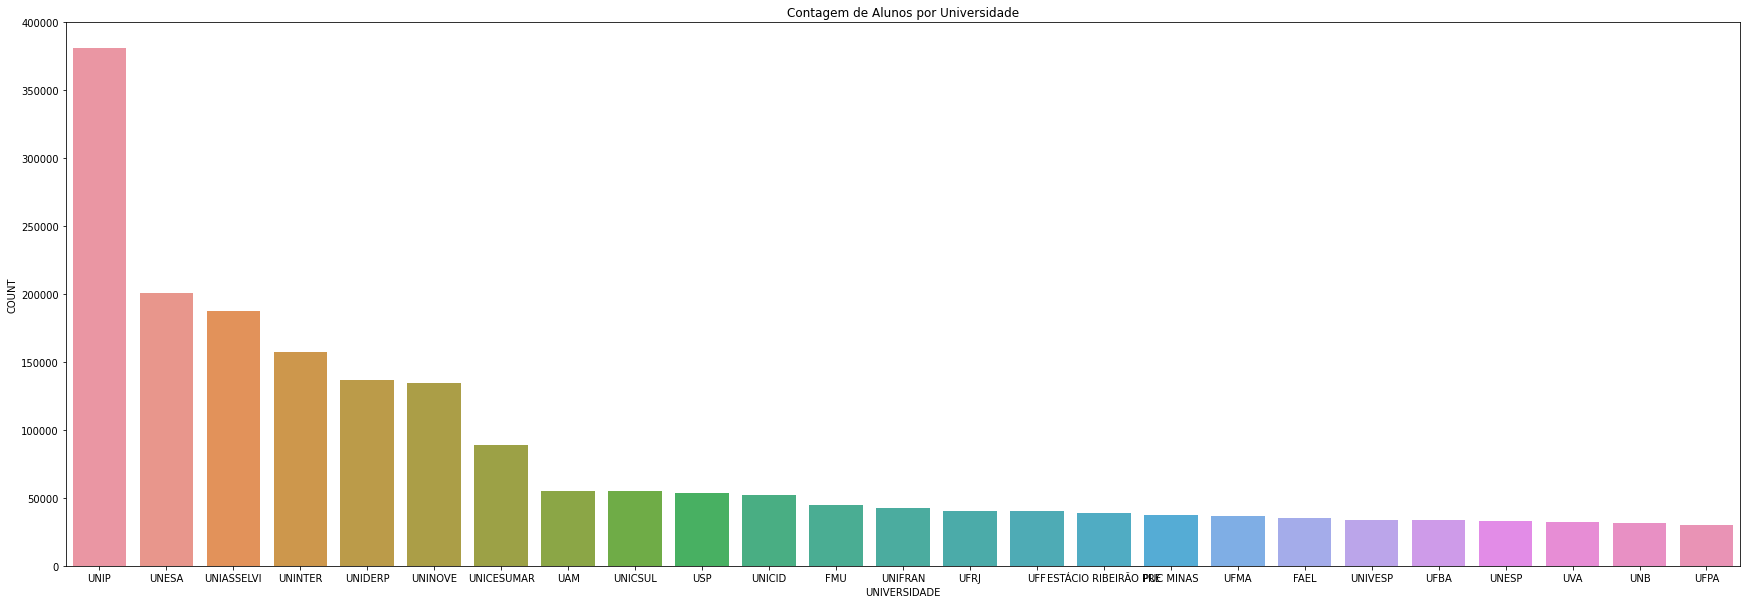

In [13]:
plt.figure(figsize=(30,10))
plt.title('Contagem de Alunos por Universidade')
sns.barplot(data=df_alunos_universidade[:25], x='UNIVERSIDADE', y='COUNT')

As faculdades particulares possuem beeeeem mais alunos que as faculdades publicas. Existem algumas hipoteses pra isso:

- Faculdades públicas sao mais dificeis de ingressar (por conta de professo seletivos e etc)
- Faculdades particulares possuem mais opções de cursos que faculdades públicas

### É verdade que existem menos mulheres nos cursos de exatas? Explique com os dados.

In [14]:
query_join_engenharia = '''
            SELECT ALUNOS.ID_ALUNO as ID,
            ALUNOS.TP_SEXO as SEXO,
            CURSO.NO_CURSO as NOME_CURSO
            FROM DM_ALUNO as ALUNOS
            LEFT JOIN
                DM_CURSO as CURSO
                ON ALUNOS.CO_CURSO = CURSO.CO_CURSO
            WHERE
            NOME_CURSO like 'ENGENHARIA%'
            AND ALUNOS.TP_SITUACAO = 2
'''

df_engenharia = pd.read_sql_query(query_join_engenharia,db)
df_engenharia

,ID,SEXO,NOME_CURSO
0,159B6F3AB6FCA2BA614423C36D52760C,2,ENGENHARIA CIVIL
1,5A5CDFF52D339C57BFA37A390AB48B3C,2,ENGENHARIA CIVIL
2,3F4342E9D54A1E8AD9163C929C4FEE06,2,ENGENHARIA CIVIL
3,249519167D8C58A13DC4B1D95073503E,2,ENGENHARIA CIVIL
4,7175ACF66481B0070D01DC3A236A226D,2,ENGENHARIA CIVIL
...,...,...,...
851468,8B3BFED11D5775A9DBA67DEDECA43234,1,ENGENHARIA CIVIL
851469,316C1E98A173620F6AD77EFC85292ECD,2,ENGENHARIA CIVIL
851470,392C38071BACBEE8A604554D9409096F,2,ENGENHARIA CIVIL
851471,D12A57140E96DE5DE64F3D63A13C403E,2,ENGENHARIA CIVIL


In [15]:
def get_sexo(id):
    if id == 1:
        return 'F'
    else:
        return 'M'

In [16]:
df_engenharia['SEXO'] = df_engenharia['SEXO'].map(lambda x: get_sexo(x))
df_engenharia

,ID,SEXO,NOME_CURSO
0,159B6F3AB6FCA2BA614423C36D52760C,M,ENGENHARIA CIVIL
1,5A5CDFF52D339C57BFA37A390AB48B3C,M,ENGENHARIA CIVIL
2,3F4342E9D54A1E8AD9163C929C4FEE06,M,ENGENHARIA CIVIL
3,249519167D8C58A13DC4B1D95073503E,M,ENGENHARIA CIVIL
4,7175ACF66481B0070D01DC3A236A226D,M,ENGENHARIA CIVIL
...,...,...,...
851468,8B3BFED11D5775A9DBA67DEDECA43234,F,ENGENHARIA CIVIL
851469,316C1E98A173620F6AD77EFC85292ECD,M,ENGENHARIA CIVIL
851470,392C38071BACBEE8A604554D9409096F,M,ENGENHARIA CIVIL
851471,D12A57140E96DE5DE64F3D63A13C403E,M,ENGENHARIA CIVIL


In [17]:
df_alunos_engenharia = pd.DataFrame(df_engenharia['SEXO'].value_counts())
df_alunos_engenharia['Sex'] = df_alunos_engenharia.index
df_alunos_engenharia.reset_index(inplace=True, drop=True)
df_alunos_engenharia.columns= ['COUNT', 'SEXO']
df_alunos_engenharia

,COUNT,SEXO
0,620124,M
1,231349,F


<AxesSubplot:xlabel='SEXO', ylabel='COUNT'>

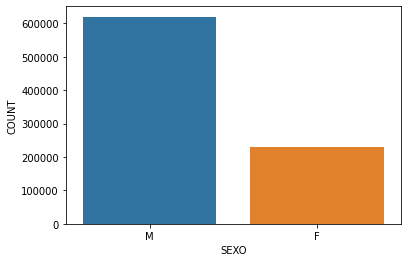

In [18]:
sns.barplot(data=df_alunos_engenharia, x='SEXO', y='COUNT')

In [19]:
homens = df_alunos_engenharia.loc[df_alunos_engenharia['SEXO'] == 'M'].values[0][0]
mulheres = df_alunos_engenharia.loc[df_alunos_engenharia['SEXO'] == 'F'].values[0][0]

In [20]:
print(f'Existem {homens} cursando engenharia e {mulheres}. Logo, o total de homens é {round(homens/mulheres*100,1)}% maior')

Existem 620124 cursando engenharia e 231349. Logo, o total de homens é 268.0% maior


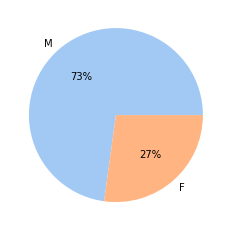

In [21]:
data = [homens, mulheres]
labels = ['M', 'F']

colors = sns.color_palette('pastel')[0:3]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

### Quantos cursos novos abrem por ano? 

In [22]:
query_cursos_novos = '''
SELECT CO_CURSO as CODIGO_CURSO, 
NO_CURSO as NOME_CURSO, 
DT_INICIO_FUNCIONAMENTO as DATA_CURSO
FROM DM_CURSO
'''

df_curso = pd.read_sql_query(query_cursos_novos, db)
df_curso

,CODIGO_CURSO,NOME_CURSO,DATA_CURSO
0,1,DIREITO,05/09/1952
1,2,CIÊNCIAS ECONÔMICAS,11/10/1968
2,3,ENGENHARIA CIVIL,11/10/1968
3,6,PEDAGOGIA,15/09/1970
4,7,SERVIÇO SOCIAL,09/03/1970
...,...,...,...
38251,5001430,GESTÃO COMERCIAL,None
38252,1458085,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,01/08/2018
38253,1458087,GESTÃO DA PRODUÇÃO INDUSTRIAL,01/08/2018
38254,1465936,GESTÃO DE ENERGIA E EFICIÊNCIA ENERGÉTICA,None


In [23]:
df_curso['DATA_CURSO'].nunique()

5528

In [24]:
df_curso.dtypes

CODIGO_CURSO     int64
NOME_CURSO      object
DATA_CURSO      object
dtype: object

In [25]:
def get_year(date):
    try:
        return date.split(r'/')[2]
    except:
        return None

In [26]:
get_year('24/03/2022')

'2022'

In [27]:
df_curso['year'] = df_curso['DATA_CURSO'].map(lambda x: get_year(x))
df_curso

,CODIGO_CURSO,NOME_CURSO,DATA_CURSO,year
0,1,DIREITO,05/09/1952,1952
1,2,CIÊNCIAS ECONÔMICAS,11/10/1968,1968
2,3,ENGENHARIA CIVIL,11/10/1968,1968
3,6,PEDAGOGIA,15/09/1970,1970
4,7,SERVIÇO SOCIAL,09/03/1970,1970
...,...,...,...,...
38251,5001430,GESTÃO COMERCIAL,None,None
38252,1458085,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,01/08/2018,2018
38253,1458087,GESTÃO DA PRODUÇÃO INDUSTRIAL,01/08/2018,2018
38254,1465936,GESTÃO DE ENERGIA E EFICIÊNCIA ENERGÉTICA,None,None


In [28]:
df_ano = pd.DataFrame(df_curso['year'].value_counts())
df_ano['ano'] = df_ano.index
df_ano.columns = ['COUNT', 'YEAR']
df_ano.reset_index(inplace=True, drop=True)
df_ano['YEAR'] = pd.to_numeric(df_ano['YEAR'])
df_ano.sort_values('YEAR', ascending=True, inplace=True)
df_ano.drop(axis = 0, index = len(df_ano)-1, inplace=True)
df_ano

,COUNT,YEAR
108,2,1808
118,1,1811
104,2,1816
115,1,1820
111,2,1828
...,...,...
4,1831,2014
1,1975,2015
5,1827,2016
9,1458,2017


<AxesSubplot:xlabel='YEAR', ylabel='COUNT'>

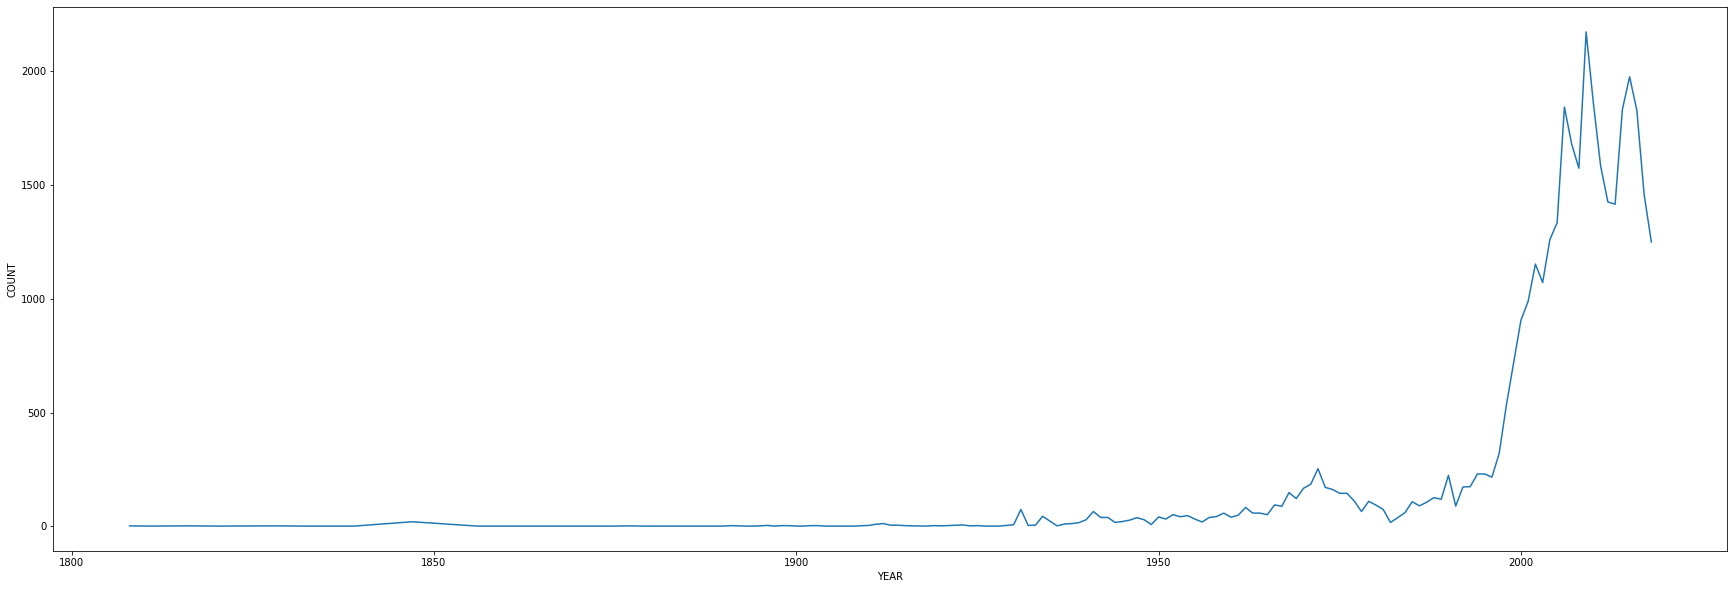

In [29]:
plt.figure(figsize=(30,10))
sns.lineplot(data = df_ano, x = 'YEAR', y='COUNT')

### A afirmação a seguir é verdadeira: Alunos da região Norte têm maior tendência a não concluírem os cursos quando comparados ao restante do país? Comprove com dados.

In [30]:
query_norte = '''
            SELECT ALUNOS.ID_ALUNO as ID,
            ALUNOS.CO_UF_NASCIMENTO as CODIGO_UF_NASCIMENTO,
            IES.SG_IES as SIGLA_UNIVERSIDADE,
            IES.CO_REGIAO as CODIGO_REGIAO,
            IES.CO_UF AS CODIGO_ESTADO
            FROM DM_ALUNO as ALUNOS
            LEFT JOIN
                DM_IES as IES
                ON ALUNOS.CO_IES = IES.CO_IES
            WHERE ALUNOS.TP_SITUACAO = 3
            OR ALUNOS.TP_SITUACAO = 4
'''

df_norte = pd.read_sql_query(query_norte,db)
df_norte

,ID,CODIGO_UF_NASCIMENTO,SIGLA_UNIVERSIDADE,CODIGO_REGIAO,CODIGO_ESTADO
0,2A9470AC3FC03AD130954809A84BC7D4,NaN,UFMT,5,51
1,E535A93D94430667B67D180C506CCB66,NaN,UFMT,5,51
2,0617FBEA7F8A7FE095AC7A425DB9C365,NaN,UFMT,5,51
3,1F6DAC46F9DCE74E16573BAD76F51453,31.0,UFMT,5,51
4,9EA96DB4ADE57D8D61047AE38393D4B6,NaN,UFMT,5,51
...,...,...,...,...,...
3483613,D8A00793CD063E7112CEEC4926F5FBAB,35.0,None,3,35
3483614,4D1FAD6D6DAF94A259BDAFEF67125268,35.0,None,3,35
3483615,45D3FF258CBBE557ACF6FFA4562926BF,22.0,None,3,35
3483616,B505440B7452768EB4E9625EFCF0B09B,35.0,None,3,35


In [31]:
df_estados

,Código da UF,UF,Estado
0,12,AC,Acre
1,27,AL,Alagoas
2,13,AM,Amazonas
3,16,AP,Amapá
4,29,BA,Bahia
5,23,CE,Ceará
6,53,DF,Distrito Federal
7,32,ES,Espírito Santo
8,52,GO,Goiás
9,21,MA,Maranhão


In [32]:
df_norte = df_norte.merge(df_estados, how='left', left_on='CODIGO_UF_NASCIMENTO', right_on='Código da UF')
df_norte.drop(['CODIGO_REGIAO', 'Código da UF', 'Estado'], inplace=True, axis=1)
df_norte.columns = ['ID', 'CODIGO_UF_NASCIMENTO', 'SIGLA_UNIVERSIDADE', 'CODIGO_ESTADO', 'UF_NASCIMENTO']
df_norte

,ID,CODIGO_UF_NASCIMENTO,SIGLA_UNIVERSIDADE,CODIGO_ESTADO,UF_NASCIMENTO
0,2A9470AC3FC03AD130954809A84BC7D4,NaN,UFMT,51,NaN
1,E535A93D94430667B67D180C506CCB66,NaN,UFMT,51,NaN
2,0617FBEA7F8A7FE095AC7A425DB9C365,NaN,UFMT,51,NaN
3,1F6DAC46F9DCE74E16573BAD76F51453,31.0,UFMT,51,MG
4,9EA96DB4ADE57D8D61047AE38393D4B6,NaN,UFMT,51,NaN
...,...,...,...,...,...
3483613,D8A00793CD063E7112CEEC4926F5FBAB,35.0,None,35,SP
3483614,4D1FAD6D6DAF94A259BDAFEF67125268,35.0,None,35,SP
3483615,45D3FF258CBBE557ACF6FFA4562926BF,22.0,None,35,PI
3483616,B505440B7452768EB4E9625EFCF0B09B,35.0,None,35,SP


In [33]:
df_norte = df_norte.merge(df_estados, how='left', left_on='CODIGO_ESTADO', right_on='Código da UF')
df_norte.drop(['CODIGO_UF_NASCIMENTO', 'CODIGO_ESTADO','Código da UF', 'Estado'], inplace=True, axis=1)
df_norte.columns = ['ID', 'SIGLA_UNIVERSIDADE', 'UF_NASCIMENTO', 'UF_UNIVERSIDADE']
df_norte

,ID,SIGLA_UNIVERSIDADE,UF_NASCIMENTO,UF_UNIVERSIDADE
0,2A9470AC3FC03AD130954809A84BC7D4,UFMT,NaN,MT
1,E535A93D94430667B67D180C506CCB66,UFMT,NaN,MT
2,0617FBEA7F8A7FE095AC7A425DB9C365,UFMT,NaN,MT
3,1F6DAC46F9DCE74E16573BAD76F51453,UFMT,MG,MT
4,9EA96DB4ADE57D8D61047AE38393D4B6,UFMT,NaN,MT
...,...,...,...,...
3483613,D8A00793CD063E7112CEEC4926F5FBAB,None,SP,SP
3483614,4D1FAD6D6DAF94A259BDAFEF67125268,None,SP,SP
3483615,45D3FF258CBBE557ACF6FFA4562926BF,None,PI,SP
3483616,B505440B7452768EB4E9625EFCF0B09B,None,SP,SP


In [34]:
def get_norte(UF):
    if (UF == 'AM' or UF == 'PA' or UF == 'RR' or UF == 'AP' or UF == 'AC' or UF == 'RO' or UF == 'TO'):
        return 'Norte'
    else:
        return 'Outra'

In [35]:
df_norte['REGIAO_NASCIMENTO'] = df_norte['UF_NASCIMENTO'].map(lambda x: get_norte(x))
df_norte['REGIAO_UNIVERSIDADE'] = df_norte['UF_UNIVERSIDADE'].map(lambda x: get_norte(x))
df_norte

,ID,SIGLA_UNIVERSIDADE,UF_NASCIMENTO,UF_UNIVERSIDADE,REGIAO_NASCIMENTO,REGIAO_UNIVERSIDADE
0,2A9470AC3FC03AD130954809A84BC7D4,UFMT,NaN,MT,Outra,Outra
1,E535A93D94430667B67D180C506CCB66,UFMT,NaN,MT,Outra,Outra
2,0617FBEA7F8A7FE095AC7A425DB9C365,UFMT,NaN,MT,Outra,Outra
3,1F6DAC46F9DCE74E16573BAD76F51453,UFMT,MG,MT,Outra,Outra
4,9EA96DB4ADE57D8D61047AE38393D4B6,UFMT,NaN,MT,Outra,Outra
...,...,...,...,...,...,...
3483613,D8A00793CD063E7112CEEC4926F5FBAB,None,SP,SP,Outra,Outra
3483614,4D1FAD6D6DAF94A259BDAFEF67125268,None,SP,SP,Outra,Outra
3483615,45D3FF258CBBE557ACF6FFA4562926BF,None,PI,SP,Outra,Outra
3483616,B505440B7452768EB4E9625EFCF0B09B,None,SP,SP,Outra,Outra


<AxesSubplot:xlabel='REGIAO_NASCIMENTO', ylabel='Count'>

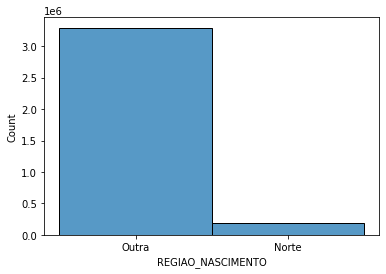

In [36]:
sns.histplot(data=df_norte, x='REGIAO_NASCIMENTO')

In [37]:
df_norte_abandonos = pd.DataFrame(df_norte['REGIAO_NASCIMENTO'].value_counts())
df_norte_abandonos['REGIAO'] = df_norte_abandonos.index
df_norte_abandonos.reset_index(inplace=True, drop=True)
df_norte_abandonos.columns = ['COUNT', 'REGIAO_NASCIMENTO']
df_norte_abandonos

,COUNT,REGIAO_NASCIMENTO
0,3292157,Outra
1,191461,Norte


In [38]:
query_norte_cursando = '''
            SELECT ALUNOS.ID_ALUNO as ID,
            ALUNOS.CO_UF_NASCIMENTO as CODIGO_UF_NASCIMENTO,
            IES.SG_IES as SIGLA_UNIVERSIDADE,
            IES.CO_REGIAO as CODIGO_REGIAO,
            IES.CO_UF AS CODIGO_ESTADO
            FROM DM_ALUNO as ALUNOS
            LEFT JOIN
                DM_IES as IES
                ON ALUNOS.CO_IES = IES.CO_IES
            WHERE ALUNOS.TP_SITUACAO = 2
'''

df_norte_cursando = pd.read_sql_query(query_norte_cursando,db)
df_norte_cursando

,ID,CODIGO_UF_NASCIMENTO,SIGLA_UNIVERSIDADE,CODIGO_REGIAO,CODIGO_ESTADO
0,2ECD7C9BEA7DCEBC31B9F2874D454F71,NaN,UFMT,5,51
1,3EA3DF175677D93C4FDD47865E89B92A,NaN,UFMT,5,51
2,EF1C01E9B84BEB8D6AA9702F59A90410,NaN,UFMT,5,51
3,E92DBC6D54AD8AC7419AC6818C9D4C3B,NaN,UFMT,5,51
4,442253EDCC14C59DA844B46DE6BFC49C,NaN,UFMT,5,51
...,...,...,...,...,...
7186965,AFB1C88C61C115085A2A1D72AC83473D,35.0,None,3,35
7186966,9DA6C77C61E8CECE5952F79D6EE59072,35.0,None,3,35
7186967,050A076096291E60A0A57FF97A4D1C43,35.0,None,3,35
7186968,E82460DEB7C48ECA4022E2F18EB11361,35.0,None,3,35


In [39]:
df_norte_cursando = df_norte_cursando.merge(df_estados, how='left', left_on='CODIGO_UF_NASCIMENTO', right_on='Código da UF')
df_norte_cursando.drop(['CODIGO_REGIAO', 'Código da UF', 'Estado'], inplace=True, axis=1)
df_norte_cursando.columns = ['ID', 'CODIGO_UF_NASCIMENTO', 'SIGLA_UNIVERSIDADE', 'CODIGO_ESTADO', 'UF_NASCIMENTO']
df_norte_cursando

,ID,CODIGO_UF_NASCIMENTO,SIGLA_UNIVERSIDADE,CODIGO_ESTADO,UF_NASCIMENTO
0,2ECD7C9BEA7DCEBC31B9F2874D454F71,NaN,UFMT,51,NaN
1,3EA3DF175677D93C4FDD47865E89B92A,NaN,UFMT,51,NaN
2,EF1C01E9B84BEB8D6AA9702F59A90410,NaN,UFMT,51,NaN
3,E92DBC6D54AD8AC7419AC6818C9D4C3B,NaN,UFMT,51,NaN
4,442253EDCC14C59DA844B46DE6BFC49C,NaN,UFMT,51,NaN
...,...,...,...,...,...
7186965,AFB1C88C61C115085A2A1D72AC83473D,35.0,None,35,SP
7186966,9DA6C77C61E8CECE5952F79D6EE59072,35.0,None,35,SP
7186967,050A076096291E60A0A57FF97A4D1C43,35.0,None,35,SP
7186968,E82460DEB7C48ECA4022E2F18EB11361,35.0,None,35,SP


In [40]:
df_norte_cursando = df_norte_cursando.merge(df_estados, how='left', left_on='CODIGO_ESTADO', right_on='Código da UF')
df_norte_cursando.drop(['CODIGO_UF_NASCIMENTO', 'CODIGO_ESTADO','Código da UF', 'Estado'], inplace=True, axis=1)
df_norte_cursando.columns = ['ID', 'SIGLA_UNIVERSIDADE', 'UF_NASCIMENTO', 'UF_UNIVERSIDADE']
df_norte_cursando

,ID,SIGLA_UNIVERSIDADE,UF_NASCIMENTO,UF_UNIVERSIDADE
0,2ECD7C9BEA7DCEBC31B9F2874D454F71,UFMT,NaN,MT
1,3EA3DF175677D93C4FDD47865E89B92A,UFMT,NaN,MT
2,EF1C01E9B84BEB8D6AA9702F59A90410,UFMT,NaN,MT
3,E92DBC6D54AD8AC7419AC6818C9D4C3B,UFMT,NaN,MT
4,442253EDCC14C59DA844B46DE6BFC49C,UFMT,NaN,MT
...,...,...,...,...
7186965,AFB1C88C61C115085A2A1D72AC83473D,None,SP,SP
7186966,9DA6C77C61E8CECE5952F79D6EE59072,None,SP,SP
7186967,050A076096291E60A0A57FF97A4D1C43,None,SP,SP
7186968,E82460DEB7C48ECA4022E2F18EB11361,None,SP,SP


In [41]:
df_norte_cursando['REGIAO_NASCIMENTO'] = df_norte_cursando['UF_NASCIMENTO'].map(lambda x: get_norte(x))
df_norte_cursando['REGIAO_UNIVERSIDADE'] = df_norte_cursando['UF_UNIVERSIDADE'].map(lambda x: get_norte(x))
df_norte_cursando

,ID,SIGLA_UNIVERSIDADE,UF_NASCIMENTO,UF_UNIVERSIDADE,REGIAO_NASCIMENTO,REGIAO_UNIVERSIDADE
0,2ECD7C9BEA7DCEBC31B9F2874D454F71,UFMT,NaN,MT,Outra,Outra
1,3EA3DF175677D93C4FDD47865E89B92A,UFMT,NaN,MT,Outra,Outra
2,EF1C01E9B84BEB8D6AA9702F59A90410,UFMT,NaN,MT,Outra,Outra
3,E92DBC6D54AD8AC7419AC6818C9D4C3B,UFMT,NaN,MT,Outra,Outra
4,442253EDCC14C59DA844B46DE6BFC49C,UFMT,NaN,MT,Outra,Outra
...,...,...,...,...,...,...
7186965,AFB1C88C61C115085A2A1D72AC83473D,None,SP,SP,Outra,Outra
7186966,9DA6C77C61E8CECE5952F79D6EE59072,None,SP,SP,Outra,Outra
7186967,050A076096291E60A0A57FF97A4D1C43,None,SP,SP,Outra,Outra
7186968,E82460DEB7C48ECA4022E2F18EB11361,None,SP,SP,Outra,Outra


<AxesSubplot:xlabel='REGIAO_NASCIMENTO', ylabel='Count'>

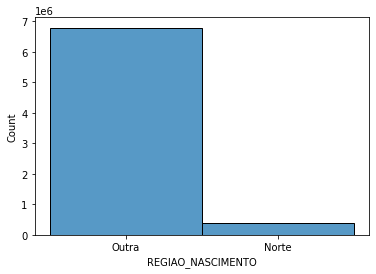

In [42]:
sns.histplot(data=df_norte_cursando, x='REGIAO_NASCIMENTO')

In [43]:
df_norte_ativos = pd.DataFrame(df_norte_cursando['REGIAO_NASCIMENTO'].value_counts())
df_norte_ativos['REGIAO'] = df_norte_ativos.index
df_norte_ativos.reset_index(inplace=True, drop=True)
df_norte_ativos.columns = ['COUNT', 'REGIAO_NASCIMENTO']
df_norte_ativos

,COUNT,REGIAO_NASCIMENTO
0,6790875,Outra
1,396095,Norte


In [44]:
df_norte_abandonos = df_norte_abandonos.merge(df_norte_ativos, how = 'left', left_on='REGIAO_NASCIMENTO', right_on='REGIAO_NASCIMENTO')
df_norte_abandonos

,COUNT_x,REGIAO_NASCIMENTO,COUNT_y
0,3292157,Outra,6790875
1,191461,Norte,396095


In [45]:
df_norte_abandonos.columns = ['ABANDONOS', 'REGIAO_NASCIMENTO', 'ATIVOS']
df_norte_abandonos

,ABANDONOS,REGIAO_NASCIMENTO,ATIVOS
0,3292157,Outra,6790875
1,191461,Norte,396095


In [46]:
df_norte_abandonos['% ABANDONO'] = round(df_norte_abandonos['ABANDONOS']/df_norte_abandonos['ATIVOS']*100,2)
df_norte_abandonos

,ABANDONOS,REGIAO_NASCIMENTO,ATIVOS,% ABANDONO
0,3292157,Outra,6790875,48.48
1,191461,Norte,396095,48.34


In [47]:
df_norte_abandonos.dtypes

ABANDONOS              int64
REGIAO_NASCIMENTO     object
ATIVOS                 int64
% ABANDONO           float64
dtype: object

<AxesSubplot:xlabel='REGIAO_NASCIMENTO', ylabel='% ABANDONO'>

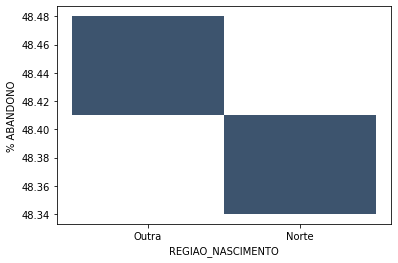

In [48]:
sns.histplot(df_norte_abandonos, x='REGIAO_NASCIMENTO', y='% ABANDONO')

### Crie uma variável que represente a taxa de abandono para cada curso. É correto afirmar professores mais/menos capacitados influenciam tal taxa?

In [49]:
query_5 = '''
SELECT ALUNOS.CO_IES as ID_IES,
ALUNOS.ID_ALUNO AS ID_ALUNO,
ALUNOS.TP_SITUACAO AS ID_SITUACAO

FROM DM_ALUNO as ALUNOS

WHERE (ALUNOS.TP_SITUACAO = 2 OR ALUNOS.TP_SITUACAO = 3 OR ALUNOS.TP_SITUACAO = 4 OR ALUNOS.TP_SITUACAO = 5)
'''

df_5 = pd.read_sql_query(query_5, db)
df_5

,ID_IES,ID_ALUNO,ID_SITUACAO
0,1,2ECD7C9BEA7DCEBC31B9F2874D454F71,2
1,1,2A9470AC3FC03AD130954809A84BC7D4,3
2,1,3EA3DF175677D93C4FDD47865E89B92A,2
3,1,E535A93D94430667B67D180C506CCB66,3
4,1,EF1C01E9B84BEB8D6AA9702F59A90410,2
...,...,...,...
10778018,23705,AEEC078F5E419031F56CC76CEFCCFEDA,2
10778019,23705,4D1FAD6D6DAF94A259BDAFEF67125268,4
10778020,23705,45D3FF258CBBE557ACF6FFA4562926BF,4
10778021,23705,B505440B7452768EB4E9625EFCF0B09B,4


In [50]:
def get_aluno_situacao(situacao):
    if situacao == 2:
        return 'Cursando'
    else:
        return 'Abandonado'

In [51]:
df_5['SITUACAO'] = df_5['ID_SITUACAO'].map(lambda x: get_aluno_situacao(x))
df_5

,ID_IES,ID_ALUNO,ID_SITUACAO,SITUACAO
0,1,2ECD7C9BEA7DCEBC31B9F2874D454F71,2,Cursando
1,1,2A9470AC3FC03AD130954809A84BC7D4,3,Abandonado
2,1,3EA3DF175677D93C4FDD47865E89B92A,2,Cursando
3,1,E535A93D94430667B67D180C506CCB66,3,Abandonado
4,1,EF1C01E9B84BEB8D6AA9702F59A90410,2,Cursando
...,...,...,...,...
10778018,23705,AEEC078F5E419031F56CC76CEFCCFEDA,2,Cursando
10778019,23705,4D1FAD6D6DAF94A259BDAFEF67125268,4,Abandonado
10778020,23705,45D3FF258CBBE557ACF6FFA4562926BF,4,Abandonado
10778021,23705,B505440B7452768EB4E9625EFCF0B09B,4,Abandonado


In [52]:
df_aluno_abandono = pd.pivot_table(df_5, values='ID_ALUNO', columns=['ID_IES','SITUACAO'], aggfunc='count').transpose()
df_aluno_abandono.reset_index(inplace=True)
df_aluno_abandono

,ID_IES,SITUACAO,ID_ALUNO
0,1,Abandonado,9957
1,1,Cursando,18500
2,2,Abandonado,9853
3,2,Cursando,31152
4,3,Abandonado,5591
...,...,...,...
4968,23459,Cursando,34
4969,23700,Abandonado,4
4970,23700,Cursando,78
4971,23705,Abandonado,16


In [53]:
df_aluno_abandono_abandonado = df_aluno_abandono.loc[df_aluno_abandono['SITUACAO'] == 'Abandonado']
df_aluno_abandono_cursando = df_aluno_abandono.loc[df_aluno_abandono['SITUACAO'] == 'Cursando']
df_taxa = df_aluno_abandono_abandonado.merge(df_aluno_abandono_cursando, how='outer', left_on='ID_IES', right_on='ID_IES')
df_taxa.drop(['SITUACAO_x', 'SITUACAO_y'], axis=1, inplace=True)
df_taxa.columns = ['ID_IES','COUNT_ABANDONADO', 'COUNT_CURSANDO']
df_taxa['TAXA_ABANDONO'] = round(df_taxa['COUNT_ABANDONADO']/df_taxa['COUNT_CURSANDO']*100,2)
df_taxa.drop(['COUNT_ABANDONADO', 'COUNT_CURSANDO'], axis=1, inplace=True)
df_taxa

,ID_IES,TAXA_ABANDONO
0,1,53.82
1,2,31.63
2,3,25.14
3,4,15.41
4,5,29.87
...,...,...
2525,21940,NaN
2526,22104,NaN
2527,22121,NaN
2528,22194,NaN


In [54]:
query_5_2 = '''
SELECT DOCENTE.CO_IES as ID_IES,
DOCENTE.TP_ESCOLARIDADE AS ESCOLARIDADE,
DOCENTE.ID_DOCENTE AS ID_DOCENTE

FROM DM_DOCENTE as DOCENTE

WHERE DOCENTE.TP_SITUACAO = 1
'''

df_5_2 = pd.read_sql_query(query_5_2, db)
df_5_2

,ID_IES,ESCOLARIDADE,ID_DOCENTE
0,1,5,F3CE8D201F9DBA7935A31AC6C8FEF33F
1,1,5,7CA2AB18D3383AF3168DCD3D4964D1F5
2,1,4,8EC22FF9220CDD6A859E555F43B20ED3
3,1,3,4C47B46F22C91D5F0A2C5D8C61F58259
4,1,5,17EB5D7EF21895C148B654225CF82235
...,...,...,...
384469,23705,4,3B78D27A87040F5298F6F5D52A92297E
384470,23705,5,48C09A30B15AEEF29851BCF69B949967
384471,23705,5,D0DC0D3206DDA554FC04EBD20243DD1E
384472,23705,5,95CC49CEB8B27CEE4271EFBE7B438E17


In [55]:
df_docentes = pd.pivot_table(df_5_2, values='ESCOLARIDADE', columns=['ID_IES','ESCOLARIDADE'], aggfunc='count').transpose()
df_docentes.reset_index(inplace=True)
df_docentes.columns = ['ID_IES', 'ESCOLARIDADE', 'COUNT']
df_docentes

,ID_IES,ESCOLARIDADE,COUNT
0,1,2,192
1,1,3,133
2,1,4,575
3,1,5,1428
4,2,2,11
...,...,...,...
7459,23700,3,1
7460,23700,4,8
7461,23700,5,6
7462,23705,4,3


In [56]:
def get_docente_escolaridade(escolaridade):
    if escolaridade == 1:
        return 'Sem graduacao'
    elif escolaridade == 2:
        return 'Graduacao'
    elif escolaridade == 3:
        return 'Especializacao'
    elif escolaridade == 4:
        return 'Mestrado'
    elif escolaridade == 5:
        return 'Doutorado'
    else:
        return None

In [57]:
df_docentes['ESCOLARIDADE'] = df_docentes['ESCOLARIDADE'].map(lambda x: get_docente_escolaridade(x))
df_docentes

,ID_IES,ESCOLARIDADE,COUNT
0,1,Graduacao,192
1,1,Especializacao,133
2,1,Mestrado,575
3,1,Doutorado,1428
4,2,Graduacao,11
...,...,...,...
7459,23700,Especializacao,1
7460,23700,Mestrado,8
7461,23700,Doutorado,6
7462,23705,Mestrado,3


In [58]:
df_docentes_total = pd.pivot_table(df_docentes, values='COUNT', columns='ID_IES', aggfunc='sum').transpose()
df_docentes_total.reset_index(inplace=True)
df_docentes_total

,ID_IES,COUNT
0,1,2328
1,2,2836
2,3,1817
3,4,1801
4,5,1746
...,...,...
2532,23410,203
2533,23438,14
2534,23459,6
2535,23700,15


In [59]:
df_docentes = df_docentes.merge(df_docentes_total, how='left', left_on='ID_IES', right_on='ID_IES')
df_docentes.columns = ['ID_IES', 'ESCOLARIDADE', 'COUNT_DOCENTES', 'TOTAL_DOCENTES']
df_docentes

,ID_IES,ESCOLARIDADE,COUNT_DOCENTES,TOTAL_DOCENTES
0,1,Graduacao,192,2328
1,1,Especializacao,133,2328
2,1,Mestrado,575,2328
3,1,Doutorado,1428,2328
4,2,Graduacao,11,2836
...,...,...,...,...
7459,23700,Especializacao,1,15
7460,23700,Mestrado,8,15
7461,23700,Doutorado,6,15
7462,23705,Mestrado,3,9


In [60]:
df_docentes['PROP_DOCENTE'] = round(df_docentes['COUNT_DOCENTES']/df_docentes['TOTAL_DOCENTES']*100,2)
df_docentes.drop(['COUNT_DOCENTES', 'TOTAL_DOCENTES'], axis=1, inplace=True)
df_docentes

,ID_IES,ESCOLARIDADE,PROP_DOCENTE
0,1,Graduacao,8.25
1,1,Especializacao,5.71
2,1,Mestrado,24.70
3,1,Doutorado,61.34
4,2,Graduacao,0.39
...,...,...,...
7459,23700,Especializacao,6.67
7460,23700,Mestrado,53.33
7461,23700,Doutorado,40.00
7462,23705,Mestrado,33.33


In [61]:
df_docentes = df_docentes.merge(df_taxa, how='left', left_on='ID_IES', right_on='ID_IES')
df_docentes

,ID_IES,ESCOLARIDADE,PROP_DOCENTE,TAXA_ABANDONO
0,1,Graduacao,8.25,53.82
1,1,Especializacao,5.71,53.82
2,1,Mestrado,24.70,53.82
3,1,Doutorado,61.34,53.82
4,2,Graduacao,0.39,31.63
...,...,...,...,...
7459,23700,Especializacao,6.67,5.13
7460,23700,Mestrado,53.33,5.13
7461,23700,Doutorado,40.00,5.13
7462,23705,Mestrado,33.33,24.62


In [62]:
df_docentes_doutorado = df_docentes.loc[df_docentes['ESCOLARIDADE'] == 'Doutorado']
df_docentes_doutorado.sort_values('PROP_DOCENTE', ascending=False, inplace=True)
df_docentes_doutorado = df_docentes_doutorado.loc[df_docentes_doutorado['TAXA_ABANDONO']<= 100]
df_docentes_doutorado

/var/folders/33/lx7s1lc53td6kjf6fs9ybgh00000gn/T/ipykernel_700/3836421300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_docentes_doutorado.sort_values('PROP_DOCENTE', ascending=False, inplace=True)


,ID_IES,ESCOLARIDADE,PROP_DOCENTE,TAXA_ABANDONO
5348,4925,Doutorado,100.00,25.76
1505,1027,Doutorado,100.00,63.70
3853,2591,Doutorado,100.00,29.75
5393,5013,Doutorado,100.00,44.37
143,56,Doutorado,98.85,19.67
...,...,...,...,...
4135,3029,Doutorado,1.82,18.17
1333,810,Doutorado,1.67,23.75
3879,2632,Doutorado,1.64,27.68
6009,14162,Doutorado,1.49,27.06


<AxesSubplot:xlabel='PROP_DOCENTE', ylabel='TAXA_ABANDONO'>

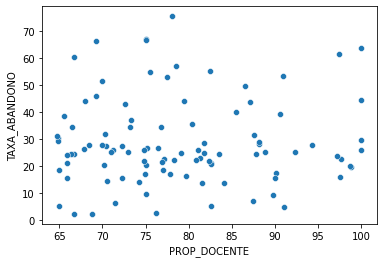

In [63]:
sns.scatterplot(data=df_docentes_doutorado[0:100], x='PROP_DOCENTE', y='TAXA_ABANDONO')

<AxesSubplot:xlabel='PROP_DOCENTE', ylabel='TAXA_ABANDONO'>

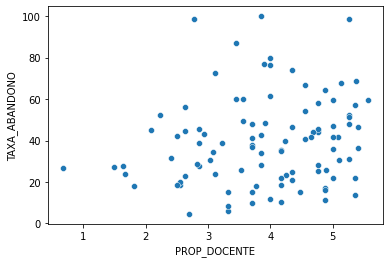

In [64]:
sns.scatterplot(data=df_docentes_doutorado[len(df_docentes_doutorado)-100:len(df_docentes_doutorado)], x='PROP_DOCENTE', y='TAXA_ABANDONO')

In [65]:
df_docentes_doutorado.corr(method='pearson')

,ID_IES,PROP_DOCENTE,TAXA_ABANDONO
ID_IES,1.000000,-0.026012,-0.063154
PROP_DOCENTE,-0.026012,1.000000,-0.138504
TAXA_ABANDONO,-0.063154,-0.138504,1.000000


<AxesSubplot:xlabel='PROP_DOCENTE', ylabel='TAXA_ABANDONO'>

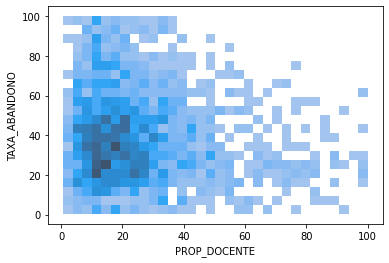

In [66]:
sns.histplot(data = df_docentes_doutorado, x='PROP_DOCENTE', y='TAXA_ABANDONO')

PARECE que quanto maior a proporcao de docentes com doutorado, menor a taxa de abandono

In [67]:
df_docentes_graduacao = df_docentes.loc[df_docentes['ESCOLARIDADE'] == 'Graduacao']
df_docentes_graduacao.sort_values('PROP_DOCENTE', ascending=False, inplace=True)
df_docentes_graduacao = df_docentes_graduacao.loc[df_docentes_graduacao['TAXA_ABANDONO']<= 100]
df_docentes_graduacao

/var/folders/33/lx7s1lc53td6kjf6fs9ybgh00000gn/T/ipykernel_700/401016350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_docentes_graduacao.sort_values('PROP_DOCENTE', ascending=False, inplace=True)


,ID_IES,ESCOLARIDADE,PROP_DOCENTE,TAXA_ABANDONO
6991,18978,Graduacao,53.66,28.20
7112,19542,Graduacao,41.67,19.51
6118,14879,Graduacao,33.33,18.75
6908,18647,Graduacao,30.00,31.58
7305,21206,Graduacao,28.12,1.03
...,...,...,...,...
958,592,Graduacao,0.12,28.80
69,21,Graduacao,0.09,46.10
874,571,Graduacao,0.08,21.06
954,591,Graduacao,0.06,23.67


<AxesSubplot:xlabel='PROP_DOCENTE', ylabel='TAXA_ABANDONO'>

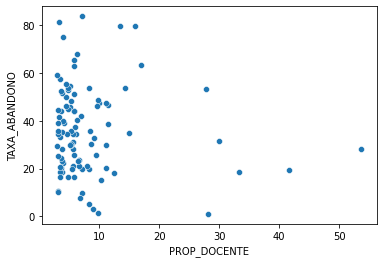

In [68]:
sns.scatterplot(data=df_docentes_graduacao[0:100], x='PROP_DOCENTE', y='TAXA_ABANDONO')

<AxesSubplot:xlabel='PROP_DOCENTE', ylabel='TAXA_ABANDONO'>

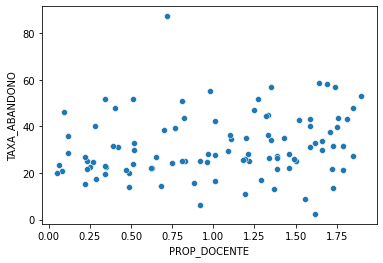

In [69]:
sns.scatterplot(data=df_docentes_graduacao[len(df_docentes_graduacao)-100:len(df_docentes_graduacao)], x='PROP_DOCENTE', y='TAXA_ABANDONO')

In [70]:
df_docentes_graduacao.corr(method='pearson')

,ID_IES,PROP_DOCENTE,TAXA_ABANDONO
ID_IES,1.000000,0.353847,0.046673
PROP_DOCENTE,0.353847,1.000000,0.006419
TAXA_ABANDONO,0.046673,0.006419,1.000000


<AxesSubplot:xlabel='PROP_DOCENTE', ylabel='TAXA_ABANDONO'>

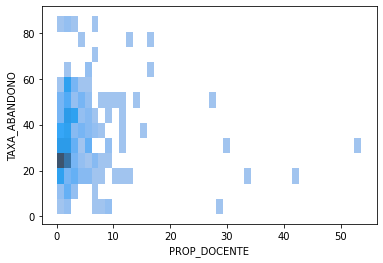

In [71]:
sns.histplot(data = df_docentes_graduacao, x='PROP_DOCENTE', y='TAXA_ABANDONO')

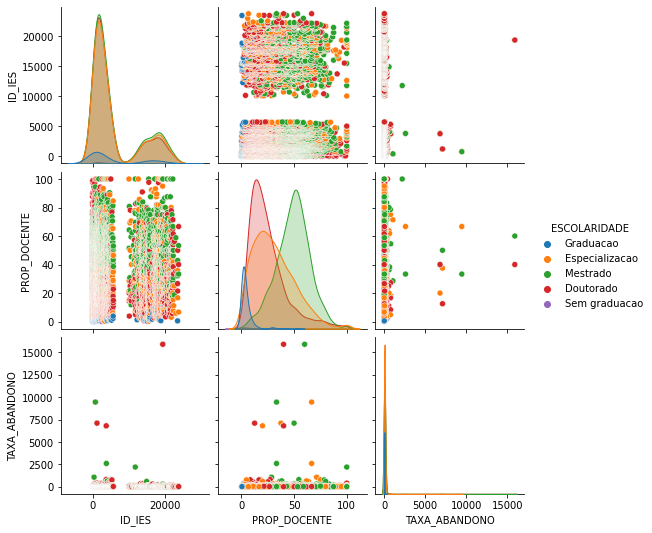

In [72]:
sns.pairplot(data=df_docentes, hue='ESCOLARIDADE')

In [73]:
df_docentes.dtypes

ID_IES             int64
ESCOLARIDADE      object
PROP_DOCENTE     float64
TAXA_ABANDONO    float64
dtype: object

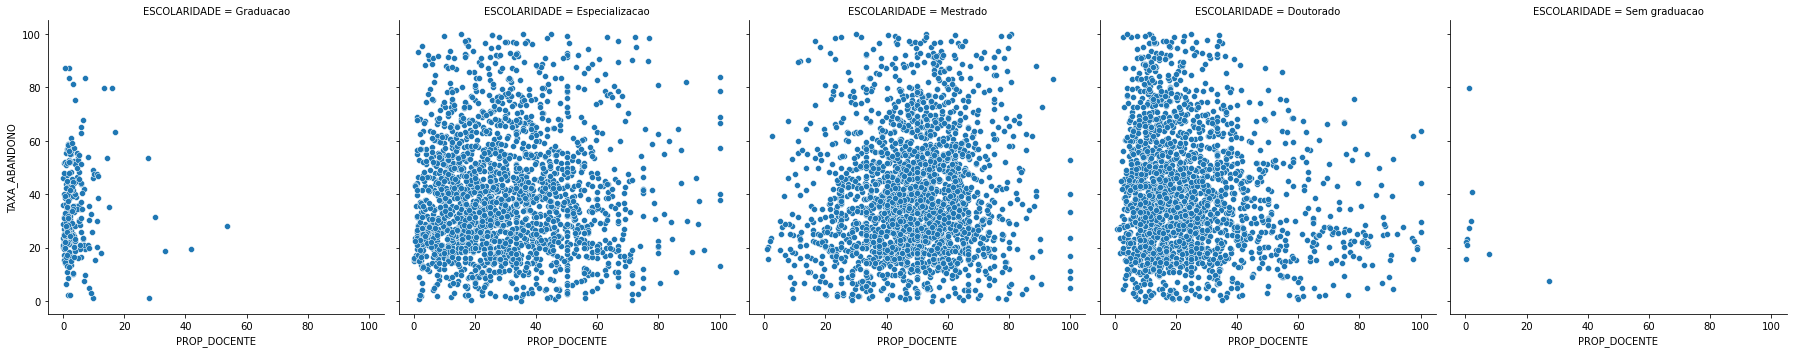

In [74]:
df_docentes_plot = df_docentes.loc[df_docentes['TAXA_ABANDONO']<=100]

sns.relplot(data=df_docentes_plot, x='PROP_DOCENTE', y='TAXA_ABANDONO', col='ESCOLARIDADE')

Aparentemente não existe uma correlaçao muito clara entre o nível de escolaridade dos docentes e a taxa de abandono

### Quais os cursos com maior crescimento de matriculas por região? E quais os com maior queda? Como você explicaria isso.

In [75]:
query_6 = '''
SELECT NO_CURSO as CURSO,
QT_INGRESSO_VAGA_NOVA as INGRESSO_VAGAS_NOVAS,
CO_UF as CODIGO_ESTADO

FROM DM_CURSO AS CURSOS
'''

cursos = pd.read_sql_query(query_6,db)
cursos

,CURSO,INGRESSO_VAGAS_NOVAS,CODIGO_ESTADO
0,DIREITO,92,51.0
1,CIÊNCIAS ECONÔMICAS,119,51.0
2,ENGENHARIA CIVIL,53,51.0
3,PEDAGOGIA,98,51.0
4,SERVIÇO SOCIAL,81,51.0
...,...,...,...
38251,GESTÃO COMERCIAL,35,35.0
38252,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,40,35.0
38253,GESTÃO DA PRODUÇÃO INDUSTRIAL,40,35.0
38254,GESTÃO DE ENERGIA E EFICIÊNCIA ENERGÉTICA,41,35.0


In [76]:
cursos = cursos.merge(df_estados, how='left', left_on='CODIGO_ESTADO', right_on='Código da UF')
cursos.drop(['CODIGO_ESTADO', 'Código da UF', 'Estado'], inplace=True, axis=1)
cursos

,CURSO,INGRESSO_VAGAS_NOVAS,UF
0,DIREITO,92,MT
1,CIÊNCIAS ECONÔMICAS,119,MT
2,ENGENHARIA CIVIL,53,MT
3,PEDAGOGIA,98,MT
4,SERVIÇO SOCIAL,81,MT
...,...,...,...
38251,GESTÃO COMERCIAL,35,SP
38252,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,40,SP
38253,GESTÃO DA PRODUÇÃO INDUSTRIAL,40,SP
38254,GESTÃO DE ENERGIA E EFICIÊNCIA ENERGÉTICA,41,SP


In [77]:
df_regioes = pd.read_csv('dados/Regioes.csv', sep=';')
df_regioes

,UF,REGIAO
0,AC,NORTE
1,PA,NORTE
2,RO,NORTE
3,RR,NORTE
4,TO,NORTE
5,MA,NORDESTE
6,PB,NORDESTE
7,PE,NORDESTE
8,PI,NORDESTE
9,RN,NORDESTE


In [78]:
cursos = cursos.merge(df_regioes, how='left', left_on='UF', right_on='UF')
cursos.drop('UF', axis=1, inplace=True)
cursos

,CURSO,INGRESSO_VAGAS_NOVAS,REGIAO
0,DIREITO,92,CENTRO-OESTE
1,CIÊNCIAS ECONÔMICAS,119,CENTRO-OESTE
2,ENGENHARIA CIVIL,53,CENTRO-OESTE
3,PEDAGOGIA,98,CENTRO-OESTE
4,SERVIÇO SOCIAL,81,CENTRO-OESTE
...,...,...,...
38251,GESTÃO COMERCIAL,35,SUDESTE
38252,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,40,SUDESTE
38253,GESTÃO DA PRODUÇÃO INDUSTRIAL,40,SUDESTE
38254,GESTÃO DE ENERGIA E EFICIÊNCIA ENERGÉTICA,41,SUDESTE


In [79]:
cursos_regiao = pd.pivot_table(cursos, values='INGRESSO_VAGAS_NOVAS', columns=['CURSO','REGIAO'], aggfunc='sum').transpose()
cursos_regiao.sort_values('INGRESSO_VAGAS_NOVAS', ascending=False, inplace=True)
cursos_regiao.reset_index(inplace=True)
cursos_regiao = cursos_regiao.loc[cursos_regiao['INGRESSO_VAGAS_NOVAS']>0]
cursos_regiao

,CURSO,REGIAO,INGRESSO_VAGAS_NOVAS
0,DIREITO,SUDESTE,92846
1,ADMINISTRAÇÃO,SUDESTE,62162
2,ENFERMAGEM,SUDESTE,40763
3,DIREITO,NORDESTE,40342
4,PEDAGOGIA,SUDESTE,38637
...,...,...,...
1804,MÚSICA - CONTRABAIXO,SUDESTE,1
1805,TURISMO RECEPTIVO,SUL,1
1806,MÚSICA - FAGOTE,SUDESTE,1
1807,MÚSICA COM HABILITAÇÃO EM INSTRUMENTO DE SOPRO...,SUDESTE,1


In [80]:
cursos_regiao.dtypes

CURSO                   object
REGIAO                  object
INGRESSO_VAGAS_NOVAS     int64
dtype: object

In [81]:
cursos_grouped = cursos_regiao.sort_values('INGRESSO_VAGAS_NOVAS', ascending=False)
cursos_grouped.drop_duplicates('REGIAO', inplace=True)
cursos_grouped

,CURSO,REGIAO,INGRESSO_VAGAS_NOVAS
0,DIREITO,SUDESTE,92846
3,DIREITO,NORDESTE,40342
7,DIREITO,SUL,28374
14,DIREITO,CENTRO-OESTE,19823
25,DIREITO,NORTE,14767


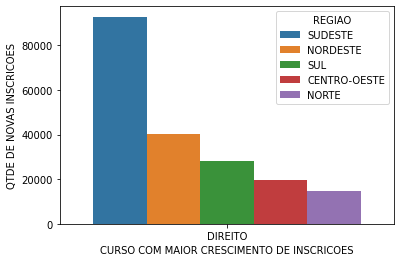

In [82]:
sns.barplot(data=cursos_grouped, x='CURSO', y='INGRESSO_VAGAS_NOVAS', hue='REGIAO')
plt.xlabel('CURSO COM MAIOR CRESCIMENTO DE INSCRICOES')
plt.ylabel('QTDE DE NOVAS INSCRICOES')
plt.show()

In [83]:
cursos_grouped_min = cursos_regiao.sort_values('INGRESSO_VAGAS_NOVAS', ascending=True)
cursos_grouped_min.drop_duplicates('REGIAO', inplace=True)
cursos_grouped_min

,CURSO,REGIAO,INGRESSO_VAGAS_NOVAS
1808,MÚSICA - CLARINETE,CENTRO-OESTE,1
1783,PRODUÇÃO SUCROALCOOLEIRA,SUDESTE,1
1782,LETRAS COM PORTUGUÊS E ESPANHOL,SUL,1
1780,AGROINDÚSTRIA,NORTE,1
1778,INTERDISCIPLINAR EM CIÊNCIAS HUMANAS E SOCIAIS...,NORDESTE,1


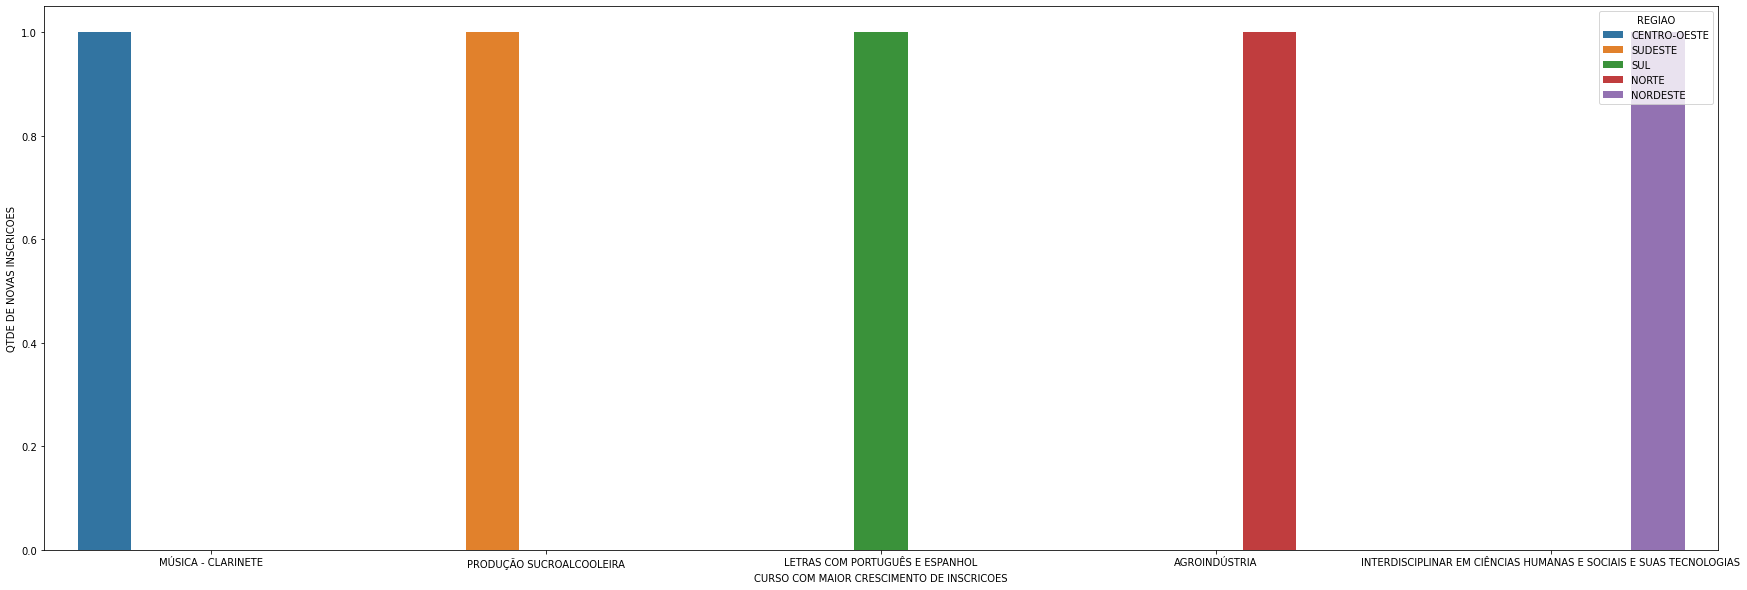

In [84]:
plt.figure(figsize=(30,10))
sns.barplot(data=cursos_grouped_min, x='CURSO', y='INGRESSO_VAGAS_NOVAS', hue='REGIAO')
plt.xlabel('CURSO COM MAIOR CRESCIMENTO DE INSCRICOES')
plt.ylabel('QTDE DE NOVAS INSCRICOES')
plt.show()

### Se você tivesse que abrir um curso (apenas um curso de graduação), qual seria, onde ele seria, qual a modalidade?

Pra isso, o ideal é pegar o curso com a maior procura (demanda)

In [85]:
query_ies = '''
SELECT NO_CURSO as CURSO,
CO_UF as COD_ESTADO,
CO_MUNICIPIO as COD_CIDADE,
QT_MATRICULA_TOTAL as QTDE_MATRICULA,
TP_MODALIDADE_ENSINO as MODALIDADE

FROM DM_CURSO as CURSO
WHERE TP_NIVEL_ACADEMICO = 1 and TP_SITUACAO = 1
'''

df_graduacao = pd.read_sql_query(query_ies, db)
df_graduacao

,CURSO,COD_ESTADO,COD_CIDADE,QTDE_MATRICULA,MODALIDADE
0,DIREITO,51.0,5103403.0,445,1
1,CIÊNCIAS ECONÔMICAS,51.0,5103403.0,344,1
2,ENGENHARIA CIVIL,51.0,5103403.0,266,1
3,PEDAGOGIA,51.0,5103403.0,326,1
4,SERVIÇO SOCIAL,51.0,5103403.0,253,1
...,...,...,...,...,...
37565,GESTÃO COMERCIAL,35.0,3500105.0,34,1
37566,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,35.0,3515707.0,38,1
37567,GESTÃO DA PRODUÇÃO INDUSTRIAL,35.0,3515707.0,40,1
37568,GESTÃO DE ENERGIA E EFICIÊNCIA ENERGÉTICA,35.0,3516408.0,33,1


In [86]:
df_graduacao.dropna(axis=0, inplace=True)
df_graduacao.sort_values('QTDE_MATRICULA', ascending=False, inplace=True)
df_graduacao = df_graduacao.merge(df_estados, how='left', left_on='COD_ESTADO', right_on='Código da UF')
df_graduacao.drop(['COD_ESTADO', 'Código da UF', 'Estado'], inplace=True, axis=1)
df_graduacao

,CURSO,COD_CIDADE,QTDE_MATRICULA,MODALIDADE,UF
0,DIREITO,3550308.0,9739,1,SP
1,DIREITO,5208707.0,6352,1,GO
2,DIREITO,2304400.0,5895,1,CE
3,DIREITO,3550308.0,5884,1,SP
4,DIREITO,5300108.0,5666,1,DF
...,...,...,...,...,...
34403,HISTÓRIA,3304557.0,0,1,RJ
34404,COMUNICAÇÃO E ILUSTRAÇÃO DIGITAL,5002704.0,0,1,MS
34405,BANCO DE DADOS,3304557.0,0,1,RJ
34406,GESTÃO EMPREENDEDORA,5002704.0,0,1,MS


In [87]:
dict_modalidade = {'Modalidade': ['Presencial', 'EAD'], 'Codigo': [1,2]}
df_modalidade = pd.DataFrame.from_dict(dict_modalidade)
df_modalidade

,Modalidade,Codigo
0,Presencial,1
1,EAD,2


In [88]:
df_graduacao = df_graduacao.merge(df_modalidade, how='left', left_on='MODALIDADE', right_on='Codigo')
df_graduacao.drop(['MODALIDADE', 'Codigo'], axis=1, inplace=True)
df_graduacao

,CURSO,COD_CIDADE,QTDE_MATRICULA,UF,Modalidade
0,DIREITO,3550308.0,9739,SP,Presencial
1,DIREITO,5208707.0,6352,GO,Presencial
2,DIREITO,2304400.0,5895,CE,Presencial
3,DIREITO,3550308.0,5884,SP,Presencial
4,DIREITO,5300108.0,5666,DF,Presencial
...,...,...,...,...,...
34403,HISTÓRIA,3304557.0,0,RJ,Presencial
34404,COMUNICAÇÃO E ILUSTRAÇÃO DIGITAL,5002704.0,0,MS,Presencial
34405,BANCO DE DADOS,3304557.0,0,RJ,Presencial
34406,GESTÃO EMPREENDEDORA,5002704.0,0,MS,Presencial


In [89]:
df_cidade = pd.read_excel(r'./anexos/ANEXO I - Dicionario de Variaveis e Tabelas Auxiliares/Tabela Municipios IBGE.xls')
df_cidade

,UF,Nome_UF,Região Geográfica Intermediária,Nome Região Geográfica Intermediária,Região Geográfica Imediata,Nome Região Geográfica Imediata,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Código Município Completo,Nome_Município
0,11,Rondônia,1102,Ji-Paraná,110005,Cacoal,2,Leste Rondoniense,6,Cacoal,15,1100015,Alta Floresta D'Oeste
1,11,Rondônia,1102,Ji-Paraná,110005,Cacoal,2,Leste Rondoniense,6,Cacoal,379,1100379,Alto Alegre dos Parecis
2,11,Rondônia,1101,Porto Velho,110002,Ariquemes,2,Leste Rondoniense,3,Ariquemes,403,1100403,Alto Paraíso
3,11,Rondônia,1102,Ji-Paraná,110004,Ji-Paraná,2,Leste Rondoniense,5,Alvorada D'Oeste,346,1100346,Alvorada D'Oeste
4,11,Rondônia,1101,Porto Velho,110002,Ariquemes,2,Leste Rondoniense,3,Ariquemes,23,1100023,Ariquemes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,52,Goiás,5201,Goiânia,520002,Anápolis,5,Sul Goiano,16,Pires do Rio,22005,5222005,Vianópolis
5566,52,Goiás,5202,Itumbiara,520009,Piracanjuba,5,Sul Goiano,15,Meia Ponte,22054,5222054,Vicentinópolis
5567,52,Goiás,5206,Luziânia - Águas Lindas de Goiás,520022,Flores de Goiás,4,Leste Goiano,12,Entorno de Brasília,22203,5222203,Vila Boa
5568,52,Goiás,5205,Porangatu - Uruaçu,520018,Ceres - Rialma - Goianésia,4,Leste Goiano,12,Entorno de Brasília,22302,5222302,Vila Propício


In [90]:
df_graduacao = df_graduacao.merge(df_cidade, how='left', left_on='COD_CIDADE', right_on='Código Município Completo')
df_graduacao.drop(['COD_CIDADE', 'UF_y', 'Nome_UF', 'Região Geográfica Intermediária', 'Nome Região Geográfica Intermediária', 'Região Geográfica Imediata', 'Nome Região Geográfica Imediata', 'Mesorregião Geográfica', 'Nome_Mesorregião', 'Microrregião Geográfica', 'Nome_Microrregião', 'Município', 'Código Município Completo'], axis=1, inplace=True)
df_graduacao

,CURSO,QTDE_MATRICULA,UF_x,Modalidade,Nome_Município
0,DIREITO,9739,SP,Presencial,São Paulo
1,DIREITO,6352,GO,Presencial,Goiânia
2,DIREITO,5895,CE,Presencial,Fortaleza
3,DIREITO,5884,SP,Presencial,São Paulo
4,DIREITO,5666,DF,Presencial,Brasília
...,...,...,...,...,...
34403,HISTÓRIA,0,RJ,Presencial,Rio de Janeiro
34404,COMUNICAÇÃO E ILUSTRAÇÃO DIGITAL,0,MS,Presencial,Campo Grande
34405,BANCO DE DADOS,0,RJ,Presencial,Rio de Janeiro
34406,GESTÃO EMPREENDEDORA,0,MS,Presencial,Campo Grande


In [94]:
curso = df_graduacao.head(1)[['CURSO']].values[0][0]
cidade = df_graduacao.head(1)[['Nome_Município']].values[0][0]
modalidade = df_graduacao.head(1)[['Modalidade']].values[0][0]

print(f'Abriria um curso de {curso} na cidade de {cidade} na modalidade {modalidade}!')

Abriria um curso de DIREITO na cidade de São Paulo na modalidade Presencial!


### Selecione um curso à sua escolha. Para este curso, considerando a taxa de abandono calculada no exerício 5, considere uma classe de 100 alunos. Além disso, considere que, para o curso se pagar, a turma deve terminar com, pelo menos, 60 alunos. Para cada aluno abaixo dos 60 alunos que desistir, o prejuízo será de 1000 reais. Assim sendo, calcule:

    - A probabilidade de a turma gerar prejuízo
    - O risco financeiro deste curso

In [101]:
query_abandono = '''
SELECT ALUNOS.ID_ALUNO AS ID_ALUNO,
ALUNOS.TP_SITUACAO AS ID_SITUACAO,
ALUNOS.CO_CURSO AS COD_CURSO

FROM DM_ALUNO as ALUNOS

WHERE (ALUNOS.TP_SITUACAO = 2 OR ALUNOS.TP_SITUACAO = 3 OR ALUNOS.TP_SITUACAO = 4 OR ALUNOS.TP_SITUACAO = 5)
'''

df_abandonos = pd.read_sql_query(query_abandono, db)
df_abandonos

,ID_ALUNO,ID_SITUACAO,COD_CURSO
0,2ECD7C9BEA7DCEBC31B9F2874D454F71,2,1
1,2A9470AC3FC03AD130954809A84BC7D4,3,1
2,3EA3DF175677D93C4FDD47865E89B92A,2,1
3,E535A93D94430667B67D180C506CCB66,3,1
4,EF1C01E9B84BEB8D6AA9702F59A90410,2,1
...,...,...,...
10778018,AEEC078F5E419031F56CC76CEFCCFEDA,2,5001434
10778019,4D1FAD6D6DAF94A259BDAFEF67125268,4,5001434
10778020,45D3FF258CBBE557ACF6FFA4562926BF,4,5001434
10778021,B505440B7452768EB4E9625EFCF0B09B,4,5001434


In [102]:
df_abandonos['SITUACAO'] = df_abandonos['ID_SITUACAO'].map(lambda x: get_aluno_situacao(x))
df_abandonos

,ID_ALUNO,ID_SITUACAO,COD_CURSO,SITUACAO
0,2ECD7C9BEA7DCEBC31B9F2874D454F71,2,1,Cursando
1,2A9470AC3FC03AD130954809A84BC7D4,3,1,Abandonado
2,3EA3DF175677D93C4FDD47865E89B92A,2,1,Cursando
3,E535A93D94430667B67D180C506CCB66,3,1,Abandonado
4,EF1C01E9B84BEB8D6AA9702F59A90410,2,1,Cursando
...,...,...,...,...
10778018,AEEC078F5E419031F56CC76CEFCCFEDA,2,5001434,Cursando
10778019,4D1FAD6D6DAF94A259BDAFEF67125268,4,5001434,Abandonado
10778020,45D3FF258CBBE557ACF6FFA4562926BF,4,5001434,Abandonado
10778021,B505440B7452768EB4E9625EFCF0B09B,4,5001434,Abandonado


In [107]:
df_abandono_1 = pd.pivot_table(df_abandonos, values='ID_ALUNO', columns=['SITUACAO', 'COD_CURSO'], aggfunc='count').transpose()
df_abandono_1.reset_index(inplace=True)
df_abandono_1

,SITUACAO,COD_CURSO,ID_ALUNO
0,Abandonado,1,68
1,Abandonado,2,239
2,Abandonado,3,55
3,Abandonado,6,135
4,Abandonado,7,154
...,...,...,...
73045,Cursando,5001434,32
73046,Cursando,5001437,54
73047,Cursando,5001451,60
73048,Cursando,5001464,52


In [121]:
df_abandono_1_1 = df_abandono_1.loc[df_abandono_1['SITUACAO'] == 'Abandonado']
df_abandono_1_2 = df_abandono_1.loc[df_abandono_1['SITUACAO'] == 'Cursando']
df_taxa_abandono = df_abandono_1_1.merge(df_abandono_1_2, how='outer', left_on='COD_CURSO', right_on='COD_CURSO')
df_taxa_abandono.drop(['SITUACAO_x', 'SITUACAO_y'], axis=1, inplace=True)
df_taxa_abandono.columns = ['COD_CURSO', 'COUNT_ABANDONADO', 'COUNT_CURSANDO']
df_taxa_abandono['TAXA_ABANDONO'] = round(df_taxa_abandono['COUNT_ABANDONADO']/df_taxa_abandono['COUNT_CURSANDO']*100,2)
df_taxa_abandono.drop(['COUNT_ABANDONADO', 'COUNT_CURSANDO'], axis=1, inplace=True)
df_taxa_abandono

,COD_CURSO,TAXA_ABANDONO
0,1,18.43
1,2,78.10
2,3,23.71
3,6,48.74
4,7,66.96
...,...,...
38073,5001197,NaN
38074,5001302,NaN
38075,5001367,NaN
38076,5001390,NaN


In [97]:
query_cursos = '''
SELECT CO_CURSO AS COD_CURSO,
NO_CURSO AS NOME_CURSO

FROM DM_CURSO
'''

df_curso = pd.read_sql_query(query_cursos, db)
df_curso

,COD_CURSO,NOME_CURSO
0,1,DIREITO
1,2,CIÊNCIAS ECONÔMICAS
2,3,ENGENHARIA CIVIL
3,6,PEDAGOGIA
4,7,SERVIÇO SOCIAL
...,...,...
38251,5001430,GESTÃO COMERCIAL
38252,1458085,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS
38253,1458087,GESTÃO DA PRODUÇÃO INDUSTRIAL
38254,1465936,GESTÃO DE ENERGIA E EFICIÊNCIA ENERGÉTICA


In [131]:
df_abandono_total = df_taxa_abandono.merge(df_curso, how='left', left_on='COD_CURSO', right_on='COD_CURSO')
df_abandono_total.dropna(inplace=True)
df_abandono_total.drop('COD_CURSO', axis=1, inplace=True)
df_abandono_total.sort_values('TAXA_ABANDONO', ascending=False, inplace=True)
df_abandono_total = df_abandono_total.loc[df_abandono_total['TAXA_ABANDONO']<=100]
df_abandono_total.reset_index(inplace=True, drop=True)
df_abandono_total

,TAXA_ABANDONO,NOME_CURSO
0,100.00,ENFERMAGEM
1,100.00,MATEMÁTICA APLICADA COM HABILITAÇÃO EM CONTROL...
2,100.00,FARMÁCIA
3,100.00,GESTÃO DE RECURSOS HUMANOS
4,100.00,LOGÍSTICA
...,...,...
29944,0.34,PEDAGOGIA
29945,0.29,HISTÓRIA
29946,0.18,ENGENHARIA ELÉTRICA
29947,0.14,ENGENHARIA MECÂNICA


In [132]:
curso = df_abandono_total.loc[df_abandono_total['TAXA_ABANDONO'] == df_abandono_total['TAXA_ABANDONO'].min()][['NOME_CURSO']].values[0][0]
taxa = df_abandono_total.loc[df_abandono_total['TAXA_ABANDONO'] == df_abandono_total['TAXA_ABANDONO'].min()][['TAXA_ABANDONO']].values[0][0]
print(f'O curso escolhido foi o curso de {curso} que possue uma taxa de abandono de {taxa}%')

O curso escolhido foi o curso de ENGENHARIA CIVIL que possue uma taxa de abandono de 0.11%


In [156]:
n = 100
p = 1 - taxa

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

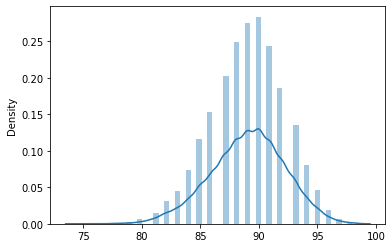

In [157]:
sucessos_alunos = np.random.binomial(n, p, size=10000)
sns.distplot(sucessos_alunos)

In [161]:
sum(sucessos_alunos < 60)/10000

0.0

In [162]:
print(f'O curso de {curso} tem {sum(sucessos_alunos < 60)/10000}% de probabilidade de gerar prejuízo :D')

O curso de ENGENHARIA CIVIL tem 0.0% de probabilidade de gerar prejuízo :D
